In [4]:
import os
import json
import gzip
import requests
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [5]:
def download_nvd_feed(year):
    feed_url = f'https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{year}.json.gz'
    response = requests.get(feed_url)

    with open(f'nvdcve-1.1-{year}.json.gz', 'wb') as f:
        f.write(response.content)

    return f'nvdcve-1.1-{year}.json.gz'


In [6]:
def extract_cve_from_item(item):
    if 'baseMetricV3' not in item['impact']:
        return None

    en_text = next(
        (desc['value'] for desc in item['cve']['description']['description_data']
         if desc['lang'] == 'en'), None)
    if en_text is None:
        return None

    en_text = en_text.replace('\n', ' ')

    return {
        'english_description': en_text,
        'cvssv3_attack_vector': item['impact']['baseMetricV3']['cvssV3']['attackVector'],
        'cvssv3_attack_complexity': item['impact']['baseMetricV3']['cvssV3']['attackComplexity'],
        'cvssv3_privileges_required': item['impact']['baseMetricV3']['cvssV3']['privilegesRequired'],
        'cvssv3_user_interaction': item['impact']['baseMetricV3']['cvssV3']['userInteraction'],
        'cvssv3_scope': item['impact']['baseMetricV3']['cvssV3']['scope'],
        'cvssv3_confidentiality_impact': item['impact']['baseMetricV3']['cvssV3']['confidentialityImpact'],
        'cvssv3_integrity_impact': item['impact']['baseMetricV3']['cvssV3']['integrityImpact'],
        'cvssv3_availability_impact': item['impact']['baseMetricV3']['cvssV3']['availabilityImpact'],
    }

In [7]:
def process_cve_data(years):
    all_cves = []
    skipped = 0
    processed = 0

    for year in years:
        filename = f'nvdcve-1.1-{year}.json.gz'

        if not os.path.exists(filename):
            print(f"Downloading data for year {year}...")
            filename = download_nvd_feed(year)
        else:
            print(f"File for year {year} already exists, using the existing file.")

        with gzip.open(filename, 'rt', encoding='utf-8') as f:
            nvd_data = json.load(f)

        print(f"Processing data for year {year}: {len(nvd_data['CVE_Items'])} total CVEs")

        year_cves = []
        for item in nvd_data['CVE_Items']:
            relevant_data = extract_cve_from_item(item)
            if relevant_data is None:
                skipped += 1
            else:
                year_cves.append(relevant_data)
                processed += 1

        all_cves.extend(year_cves)

    print(f"Processed CVEs: {processed}\nSkipped CVEs: {skipped}")
    return pd.DataFrame(all_cves)


In [36]:
years = [2022, 2023, 2024]
cvss_data = process_cve_data(years)

# Membuat kolom english_description diawali dengan tanda kutip 
cvss_data['english_description'] = cvss_data['english_description'].apply(lambda x: f'"{x}"')

# CLEANING : Ganti semua newline dengan spasi di kolom 'english_description'
cvss_data['english_description'] = cvss_data['english_description'].str.replace(r'[\n\r]+', ' ', regex=True)

# Simpan data ke dalam file CSV jika diperlukan
cvss_data.to_csv('cvss_data.csv', index=False)

# Membuat direktori 'data' jika belum ada
if not os.path.exists('data'):
    os.makedirs('data')

# Memisahkan data menjadi training dan testing (80% train, 20% test)
train_data, test_data = train_test_split(cvss_data, test_size=0.2, random_state=42)

# Menyimpan data ke dalam file CSV
train_data.to_csv('data/train.csv', index=False)
test_data.to_csv('data/test.csv', index=False)

print("Data berhasil dipisahkan menjadi 'data/train.csv' dan 'data/test.csv'.")

File for year 2022 already exists, using the existing file.
Processing data for year 2022: 25287 total CVEs
File for year 2023 already exists, using the existing file.
Processing data for year 2023: 29079 total CVEs
File for year 2024 already exists, using the existing file.
Processing data for year 2024: 32859 total CVEs
Processed CVEs: 60400
Skipped CVEs: 26825
Data berhasil dipisahkan menjadi 'data/train.csv' dan 'data/test.csv'.


In [28]:
print(cvss_data.describe(include='all'))

                                      english_description  \
count                                               60400   
unique                                              57505   
top     "Adobe Experience Manager versions 6.5.20 and ...   
freq                                                  101   

       cvssv3_attack_vector cvssv3_attack_complexity  \
count                 60400                    60400   
unique                    4                        2   
top                 NETWORK                      LOW   
freq                  44435                    58319   

       cvssv3_privileges_required cvssv3_user_interaction cvssv3_scope  \
count                       60400                   60400        60400   
unique                          3                       2            2   
top                          NONE                    NONE    UNCHANGED   
freq                        32824                   40300        48334   

       cvssv3_confidentiality_impact cvssv

In [29]:
print(cvss_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60400 entries, 0 to 60399
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   english_description            60400 non-null  object
 1   cvssv3_attack_vector           60400 non-null  object
 2   cvssv3_attack_complexity       60400 non-null  object
 3   cvssv3_privileges_required     60400 non-null  object
 4   cvssv3_user_interaction        60400 non-null  object
 5   cvssv3_scope                   60400 non-null  object
 6   cvssv3_confidentiality_impact  60400 non-null  object
 7   cvssv3_integrity_impact        60400 non-null  object
 8   cvssv3_availability_impact     60400 non-null  object
dtypes: object(9)
memory usage: 4.1+ MB
None


In [30]:
print(cvss_data.head)

<bound method NDFrame.head of                                      english_description cvssv3_attack_vector  \
0      "Non-transparent sharing of branch predictor s...                LOCAL   
1      "Non-transparent sharing of branch predictor w...                LOCAL   
2      "Hardware debug modes and processor INIT setti...             PHYSICAL   
3      "Sensitive information accessible by physical ...             PHYSICAL   
4      "Insertion of Sensitive Information into Log F...                LOCAL   
...                                                  ...                  ...   
60395  "Enterprise Cloud Database from Ragic does not...              NETWORK   
60396  "A vulnerability was found in code-projects Bl...              NETWORK   
60397  "A post-authentication SQL Injection vulnerabi...              NETWORK   
60398  "A maliciously crafted DWG file when parsed in...                LOCAL   
60399  "A maliciously crafted DWG file when parsed in...                LOCAL  

In [31]:
print("\nUnique Values per Column:")
print(cvss_data.nunique())


Unique Values per Column:
english_description              57505
cvssv3_attack_vector                 4
cvssv3_attack_complexity             2
cvssv3_privileges_required           3
cvssv3_user_interaction              2
cvssv3_scope                         2
cvssv3_confidentiality_impact        3
cvssv3_integrity_impact              3
cvssv3_availability_impact           3
dtype: int64


In [32]:
# Missing values per kolom
print("\nMissing Values per Column:")
print(cvss_data.isnull().sum())

# Persentase missing values
missing_percentage = cvss_data.isnull().mean() * 100
print("\nPercentage of Missing Values:")
print(missing_percentage)


Missing Values per Column:
english_description              0
cvssv3_attack_vector             0
cvssv3_attack_complexity         0
cvssv3_privileges_required       0
cvssv3_user_interaction          0
cvssv3_scope                     0
cvssv3_confidentiality_impact    0
cvssv3_integrity_impact          0
cvssv3_availability_impact       0
dtype: int64

Percentage of Missing Values:
english_description              0.0
cvssv3_attack_vector             0.0
cvssv3_attack_complexity         0.0
cvssv3_privileges_required       0.0
cvssv3_user_interaction          0.0
cvssv3_scope                     0.0
cvssv3_confidentiality_impact    0.0
cvssv3_integrity_impact          0.0
cvssv3_availability_impact       0.0
dtype: float64


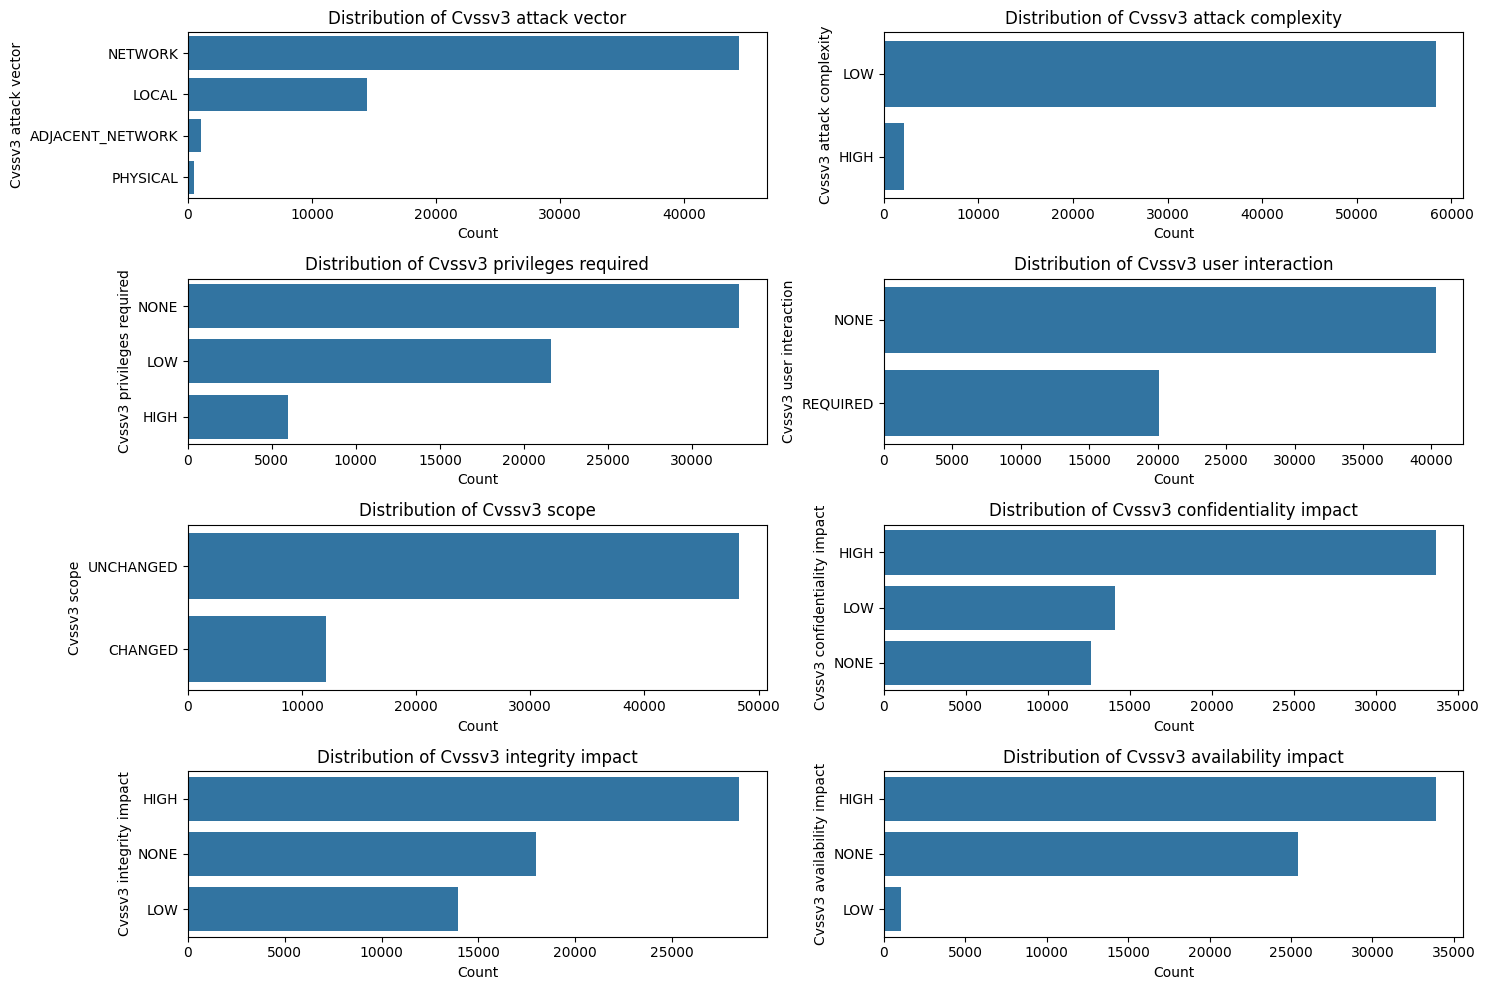

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualisasi distribusi per kategori
categories = [
    'cvssv3_attack_vector', 'cvssv3_attack_complexity', 'cvssv3_privileges_required',
    'cvssv3_user_interaction', 'cvssv3_scope', 'cvssv3_confidentiality_impact',
    'cvssv3_integrity_impact', 'cvssv3_availability_impact'
]

plt.figure(figsize=(15, 10))
for i, category in enumerate(categories):
    plt.subplot(4, 2, i + 1)
    sns.countplot(y=category, data=cvss_data, order=cvss_data[category].value_counts().index)
    plt.title(f"Distribution of {category.replace('_', ' ').capitalize()}")
    plt.xlabel('Count')
    plt.ylabel(category.replace('_', ' ').capitalize())

plt.tight_layout()
plt.show()


In [34]:
print(cvss_data.shape)

(60400, 9)


In [37]:
# Distribusi setiap kategori
for category in categories:
    print(f"\nDistribusi untuk {category}:")
    print(cvss_data[category].value_counts(normalize=True) * 100)


Distribusi untuk cvssv3_attack_vector:
cvssv3_attack_vector
NETWORK             73.567881
LOCAL               23.839404
ADJACENT_NETWORK     1.710265
PHYSICAL             0.882450
Name: proportion, dtype: float64

Distribusi untuk cvssv3_attack_complexity:
cvssv3_attack_complexity
LOW     96.554636
HIGH     3.445364
Name: proportion, dtype: float64

Distribusi untuk cvssv3_privileges_required:
cvssv3_privileges_required
NONE    54.344371
LOW     35.761589
HIGH     9.894040
Name: proportion, dtype: float64

Distribusi untuk cvssv3_user_interaction:
cvssv3_user_interaction
NONE        66.721854
REQUIRED    33.278146
Name: proportion, dtype: float64

Distribusi untuk cvssv3_scope:
cvssv3_scope
UNCHANGED    80.023179
CHANGED      19.976821
Name: proportion, dtype: float64

Distribusi untuk cvssv3_confidentiality_impact:
cvssv3_confidentiality_impact
HIGH    55.718543
LOW     23.355960
NONE    20.925497
Name: proportion, dtype: float64

Distribusi untuk cvssv3_integrity_impact:
cvssv3_inte

count    60400.000000
mean       327.761705
std        327.913624
min         23.000000
25%        162.000000
50%        251.000000
75%        393.000000
max       4000.000000
Name: description_length, dtype: float64


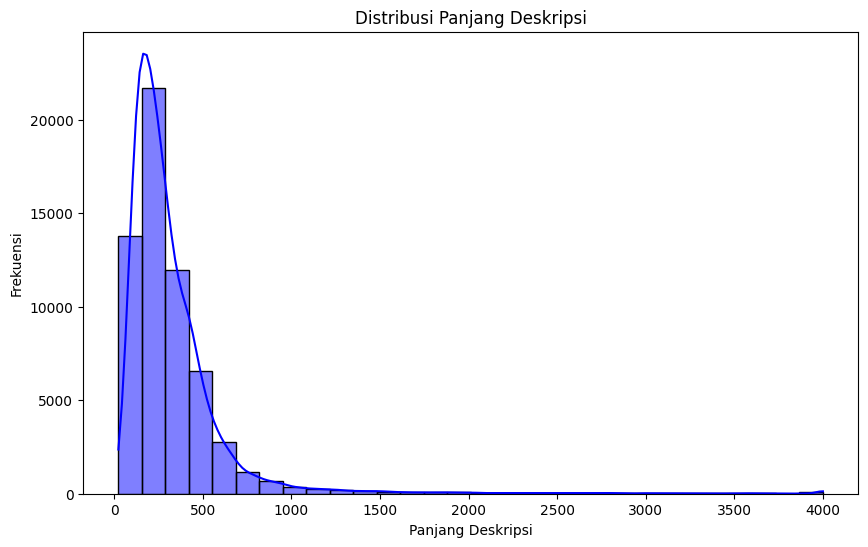

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Menghitung panjang teks
cvss_data['description_length'] = cvss_data['english_description'].apply(len)

# Statistik deskriptif
length_stats = cvss_data['description_length'].describe()
print(length_stats)

# Visualisasi distribusi panjang teks
plt.figure(figsize=(10, 6))
sns.histplot(cvss_data['description_length'], kde=True, bins=30, color='blue')
plt.title('Distribusi Panjang Deskripsi')
plt.xlabel('Panjang Deskripsi')
plt.ylabel('Frekuensi')
plt.show()

count    60400.000000
mean        46.909636
std         42.028108
min          2.000000
25%         23.000000
50%         37.000000
75%         58.000000
max        638.000000
Name: word_count, dtype: float64


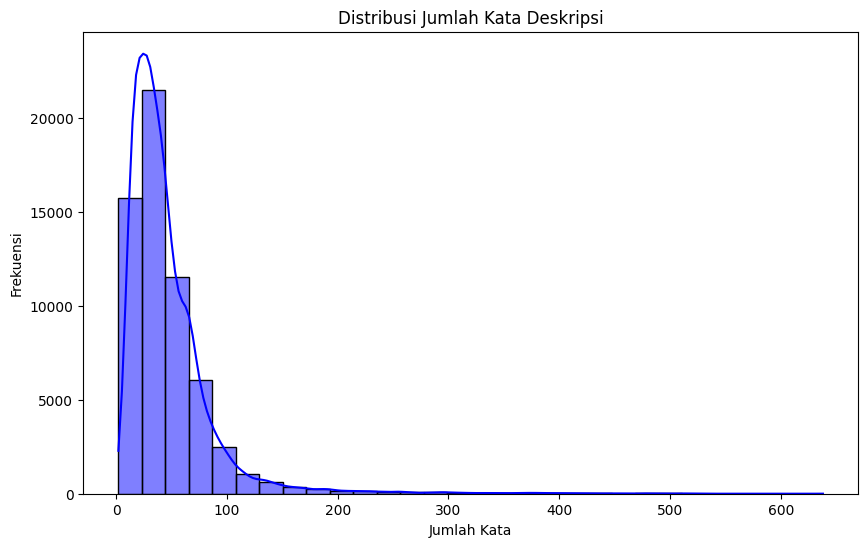

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate word count and add it as a new column
cvss_data['word_count'] = cvss_data['english_description'].apply(lambda x: len(x.split()))

# Statistik deskriptif
length_stats = cvss_data['word_count'].describe()
print(length_stats)

# Visualisasi distribusi panjang teks
plt.figure(figsize=(10, 6))
sns.histplot(cvss_data['word_count'], kde=True, bins=30, color='blue')
plt.title('Distribusi Jumlah Kata Deskripsi')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()

In [40]:
# Mencari indeks teks terpanjang dan terpendek
longest_index = cvss_data['english_description'].apply(len).idxmax()
shortest_index = cvss_data['english_description'].apply(len).idxmin()

# Mengambil teks terpanjang dan terpendek
longest_text = cvss_data.loc[longest_index, 'english_description']
shortest_text = cvss_data.loc[shortest_index, 'english_description']

# Menampilkan teks terpanjang dan terpendek
print("Teks Terpanjang:\n", longest_text)
print("\nTeks Terpendek:\n", shortest_text)

Teks Terpanjang:
 "In the Linux kernel, the following vulnerability has been resolved:  drm/i915/gem: Really move i915_gem_context.link under ref protection  i915_perf assumes that it can use the i915_gem_context reference to protect its i915->gem.contexts.list iteration. However, this requires that we do not remove the context from the list until after we drop the final reference and release the struct. If, as currently, we remove the context from the list during context_close(), the link.next pointer may be poisoned while we are holding the context reference and cause a GPF:  [ 4070.573157] i915 0000:00:02.0: [drm:i915_perf_open_ioctl [i915]] filtering on ctx_id=0x1fffff ctx_id_mask=0x1fffff [ 4070.574881] general protection fault, probably for non-canonical address 0xdead000000000100: 0000 [#1] PREEMPT SMP [ 4070.574897] CPU: 1 PID: 284392 Comm: amd_performance Tainted: G            E     5.17.9 #180 [ 4070.574903] Hardware name: Intel Corporation NUC7i5BNK/NUC7i5BNB, BIOS BNKBL357.